In [3]:
import pandas as pd

import _background as bg
import molNet
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader
from molNet.featurizer.atom_featurizer import atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, \
    atom_is_aromatic, atom_is_in_ring, atom_symbol_one_hot_from_set, atom_total_degree_one_hot, atom_chiral_tag_one_hot, atom_total_num_H_one_hot
from molNet.featurizer.featurizer import FeaturizerList
import pytorch_lightning as pl
import torch

In [4]:
dataset = pd.read_csv("data/delaney-processed.csv")

In [5]:
dataset

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [6]:
#dataset["rd_mol"]=dataset["smiles"].apply(bg.MolFromSmiles)
#c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)
from molNet.featurizer.featurizer import OneHotFeaturizer
def _get_atom_symbol(atom):
    return atom.GetSymbol()
c_mp_atom_symbol_featurizer = OneHotFeaturizer(
    possible_values=['O', 'Si', 'Na', 'H', 'P', 'F', 'S', 'C', 'Cl', 'N', 'B', 'Br','I',None],
    pre_featurize=_get_atom_symbol,
    name="atom_symbol_one_hot",
)

featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_total_degree_one_hot,
    atom_formal_charge,
    atom_partial_charge,
    atom_chiral_tag_one_hot,
    #atom_total_num_H_one_hot,
    atom_hybridization_one_hot,
    atom_is_aromatic,
    atom_is_in_ring,
])
len(featurizer)

38

In [7]:
loader_ESOLModel1 = PytorchGeomMolDfLoader(dataset,
                                         y_columns=["measured log solubility in mols per litre"],
                                         columns=[],
                                         atom_featurizer=featurizer,
                                         inplace=True,
                                         seed=1,
                                         batch_size=512,
                                         to_graph_input_kwargs=dict(
                                             #with_mol_graph=True
                                         ),
                                          #worker=1
                                         path="test/esol1.pckl",
                                         )


In [8]:
%%time
loader_ESOLModel1.setup()
for d in loader_ESOLModel1.test_dataloader():
    display(d)
    break

Batch(batch=[4230], edge_index=[2, 8550], x=[4230, 38], x_graph_features=[169, 0], y=[4230, 0], y_graph_features=[169, 1])

CPU times: user 329 ms, sys: 0 ns, total: 329 ms
Wall time: 344 ms


In [13]:
model_ESOLModel1 = bg.ChemGCModel(in_size=len(featurizer),
                          out_size=1,
                              n_chem_layer = 14,
                              chem_layer_feats_out=64,
                              chem_layer_gc_out=32,
                              chem_layer_net_sizes=-1,
                              chem_layer_net_count=2,
                              collector_net_depth=5,
                              collector_net_depth_red_fac=2,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.001,
                                lossf=torch.nn.RMSELoss()
                             )

In [14]:
study=bg.load_study("ESOLModel1")
print(len(study.trials))
study.best_trial

[I 2021-06-23 15:23:05,147] Using an existing study with name 'ESOLModel1_study' instead of creating a new one.


1436


FrozenTrial(number=390, values=[0.5807889699935913], datetime_start=datetime.datetime(2021, 5, 18, 21, 12, 25, 127142), datetime_complete=datetime.datetime(2021, 5, 18, 21, 14, 14, 119572), params={'chem_layer_feats_out': 14, 'chem_layer_gc_out': 62, 'chem_layer_net_count': 2, 'chem_layer_net_sizes': 59, 'collector_net_depth': 3, 'collector_net_depth_red_fac': 1.787419748059664, 'dropout': 0.09747151699461665, 'lr': 0.003722726846488404, 'n_chem_layer': 8, 'use_pool_max': True, 'use_pool_mean': True, 'use_pool_min': False, 'use_pool_nwsum': False, 'use_pool_sum': True, 'use_pool_wsum': True}, distributions={'chem_layer_feats_out': IntUniformDistribution(high=64, low=12, step=1), 'chem_layer_gc_out': IntUniformDistribution(high=64, low=8, step=1), 'chem_layer_net_count': IntUniformDistribution(high=3, low=1, step=1), 'chem_layer_net_sizes': IntUniformDistribution(high=64, low=0, step=1), 'collector_net_depth': IntUniformDistribution(high=8, low=2, step=1), 'collector_net_depth_red_fac':

In [ ]:
   
trial=bg.trialwrapper()

from pytorch_lightning.callbacks.early_stopping import EarlyStopping


pool_names=["pool_min","pool_max","pool_mean","pool_sum","pool_wsum","pool_nwsum"]
sudy=bg.optimize_model(model_ESOLModel1.__class__,"ESOLModel1",loader_ESOLModel1,n_trials=1,
                fixed_params=dict(in_size=len(featurizer),out_size=1,lossf=torch.nn.RMSELoss()),
                suggestion_params=dict(
                    lr=trial.suggest_loguniform("lr",1e-4, 1e-2),
                    n_chem_layer = trial.suggest_int("n_chem_layer",2,12),
                    chem_layer_feats_out=trial.suggest_int("chem_layer_feats_out",12,64),
                    chem_layer_gc_out=trial.suggest_int("chem_layer_gc_out",8,64),
                    chem_layer_net_sizes=trial.suggest_int("chem_layer_net_sizes",0,64),
                    chem_layer_net_count=trial.suggest_int("chem_layer_net_count",1,3),
                    collector_net_depth=trial.suggest_int("collector_net_depth",2,8),
                    collector_net_depth_red_fac=trial.suggest_float("collector_net_depth_red_fac",1,3),
                    dropout=trial.suggest_float("dropout",0,1),
                    poolings=trial.suggest_multiple(
                        values=pool_names,
                        names = ["use_"+pn for pn in pool_names],
                        minimum=1,
                    ),
                ),
                  verbose=True,
                  trainer_params=dict(
                      max_epochs=1000,
                      callbacks=lambda:[EarlyStopping(
                        monitor='val_loss',patience=40,
                            min_delta=0.0,
                        )]
                  )
                 )

In [15]:
study.best_trial.params

{'chem_layer_feats_out': 14,
 'chem_layer_gc_out': 62,
 'chem_layer_net_count': 2,
 'chem_layer_net_sizes': 59,
 'collector_net_depth': 3,
 'collector_net_depth_red_fac': 1.787419748059664,
 'dropout': 0.09747151699461665,
 'lr': 0.003722726846488404,
 'n_chem_layer': 8,
 'use_pool_max': True,
 'use_pool_mean': True,
 'use_pool_min': False,
 'use_pool_nwsum': False,
 'use_pool_sum': True,
 'use_pool_wsum': True}

In [16]:
pools= []
if study.best_trial.params["use_pool_max"]:
    pools.append("pool_max")
if study.best_trial.params["use_pool_min"]:
    pools.append("pool_min")
if study.best_trial.params["use_pool_mean"]:
    pools.append("pool_mean")
if study.best_trial.params["use_pool_nwsum"]:
    pools.append("pool_nwsum")
if study.best_trial.params["use_pool_sum"]:
    pools.append("pool_sum")
if study.best_trial.params["use_pool_wsum"]:
    pools.append("pool_wsum")
print(pools)
model_ESOLModel1 = model_ESOLModel1.__class__(
    in_size=len(featurizer),
    out_size=1,
    lossf=torch.nn.RMSELoss(),
    n_chem_layer = study.best_trial.params["n_chem_layer"],
    chem_layer_feats_out=study.best_trial.params["chem_layer_feats_out"],
    chem_layer_gc_out=study.best_trial.params["chem_layer_gc_out"],
    chem_layer_net_sizes=study.best_trial.params["chem_layer_net_sizes"],
    chem_layer_net_count=study.best_trial.params["chem_layer_net_count"],
    collector_net_depth=study.best_trial.params["collector_net_depth"],
    collector_net_depth_red_fac=study.best_trial.params["collector_net_depth_red_fac"],
    poolings=pools,
    lr=study.best_trial.params["lr"],
    dropout=study.best_trial.params["dropout"],
                                            
)

['pool_max', 'pool_mean', 'pool_sum', 'pool_wsum']


In [17]:
study.best_trial.params

{'chem_layer_feats_out': 14,
 'chem_layer_gc_out': 62,
 'chem_layer_net_count': 2,
 'chem_layer_net_sizes': 59,
 'collector_net_depth': 3,
 'collector_net_depth_red_fac': 1.787419748059664,
 'dropout': 0.09747151699461665,
 'lr': 0.003722726846488404,
 'n_chem_layer': 8,
 'use_pool_max': True,
 'use_pool_mean': True,
 'use_pool_min': False,
 'use_pool_nwsum': False,
 'use_pool_sum': True,
 'use_pool_wsum': True}

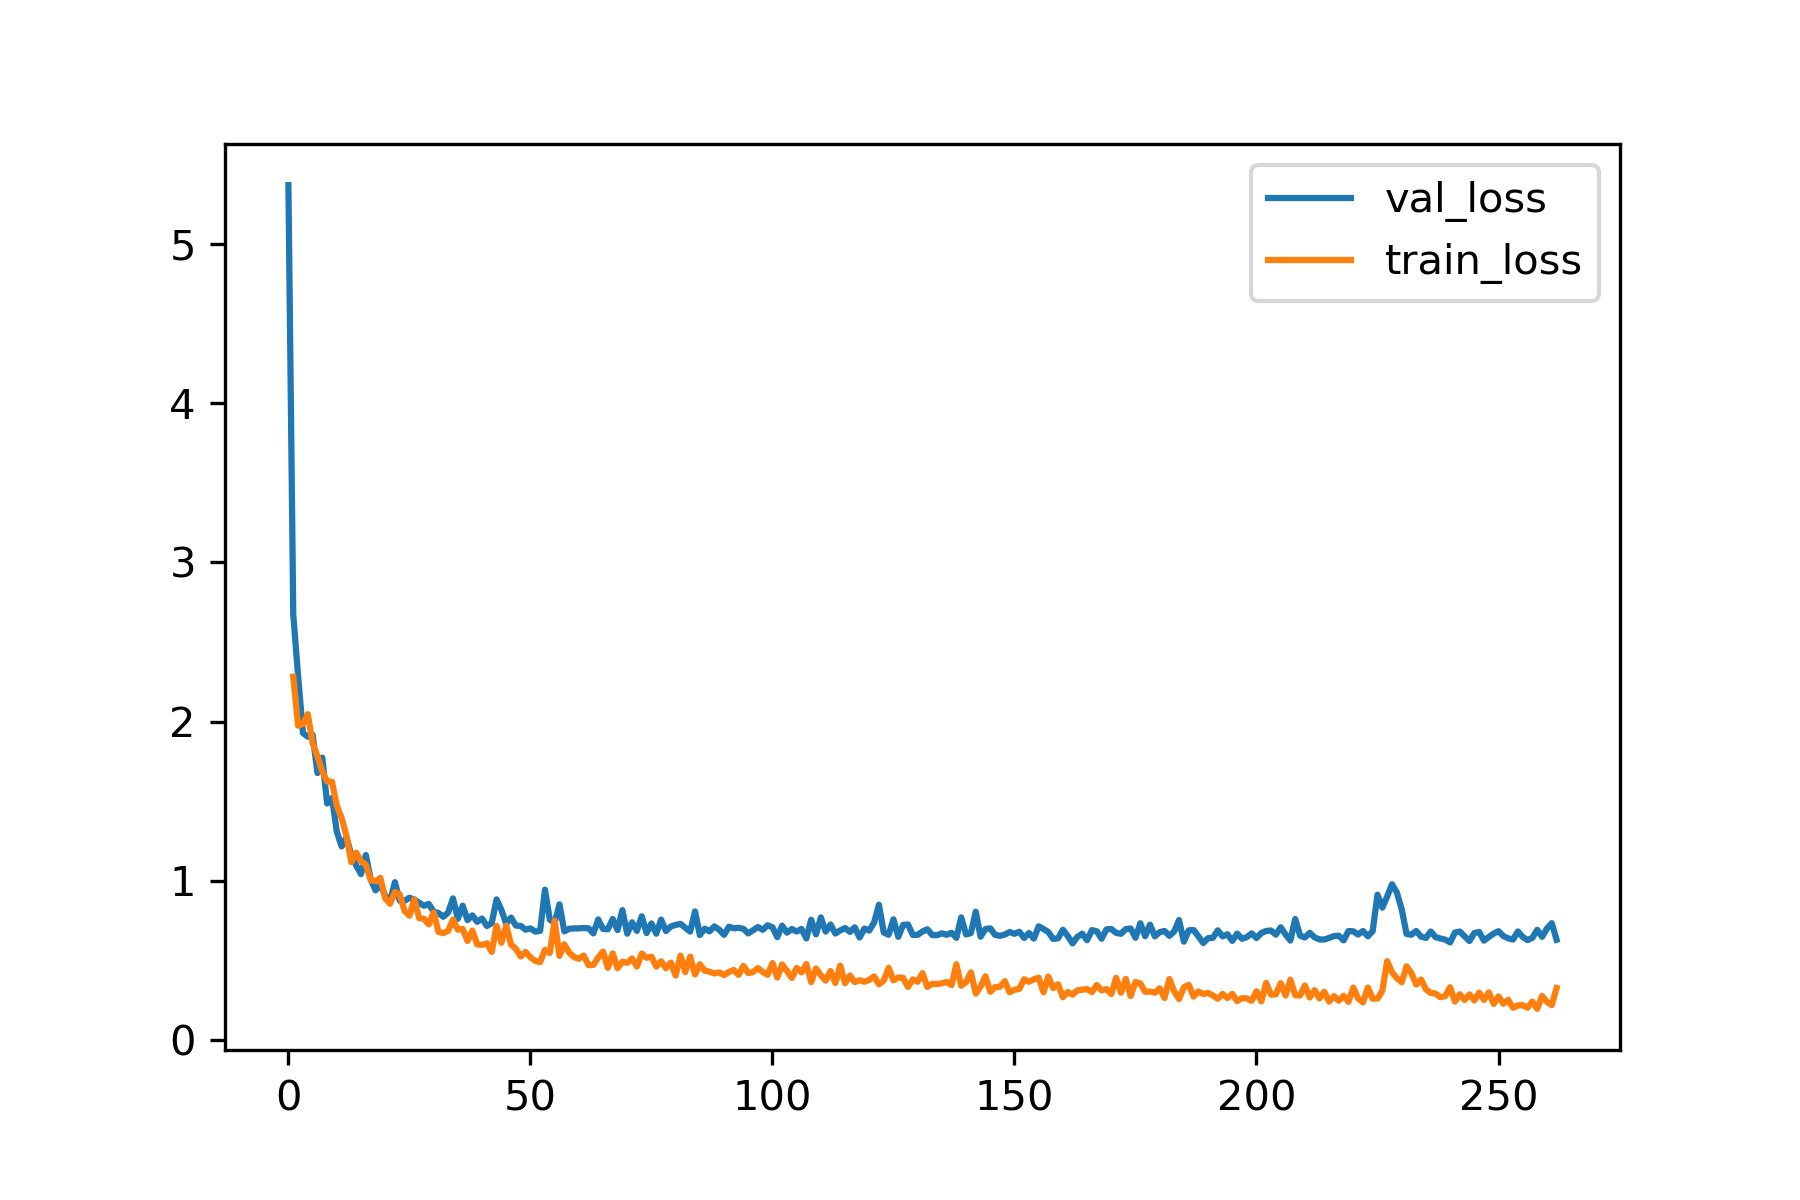

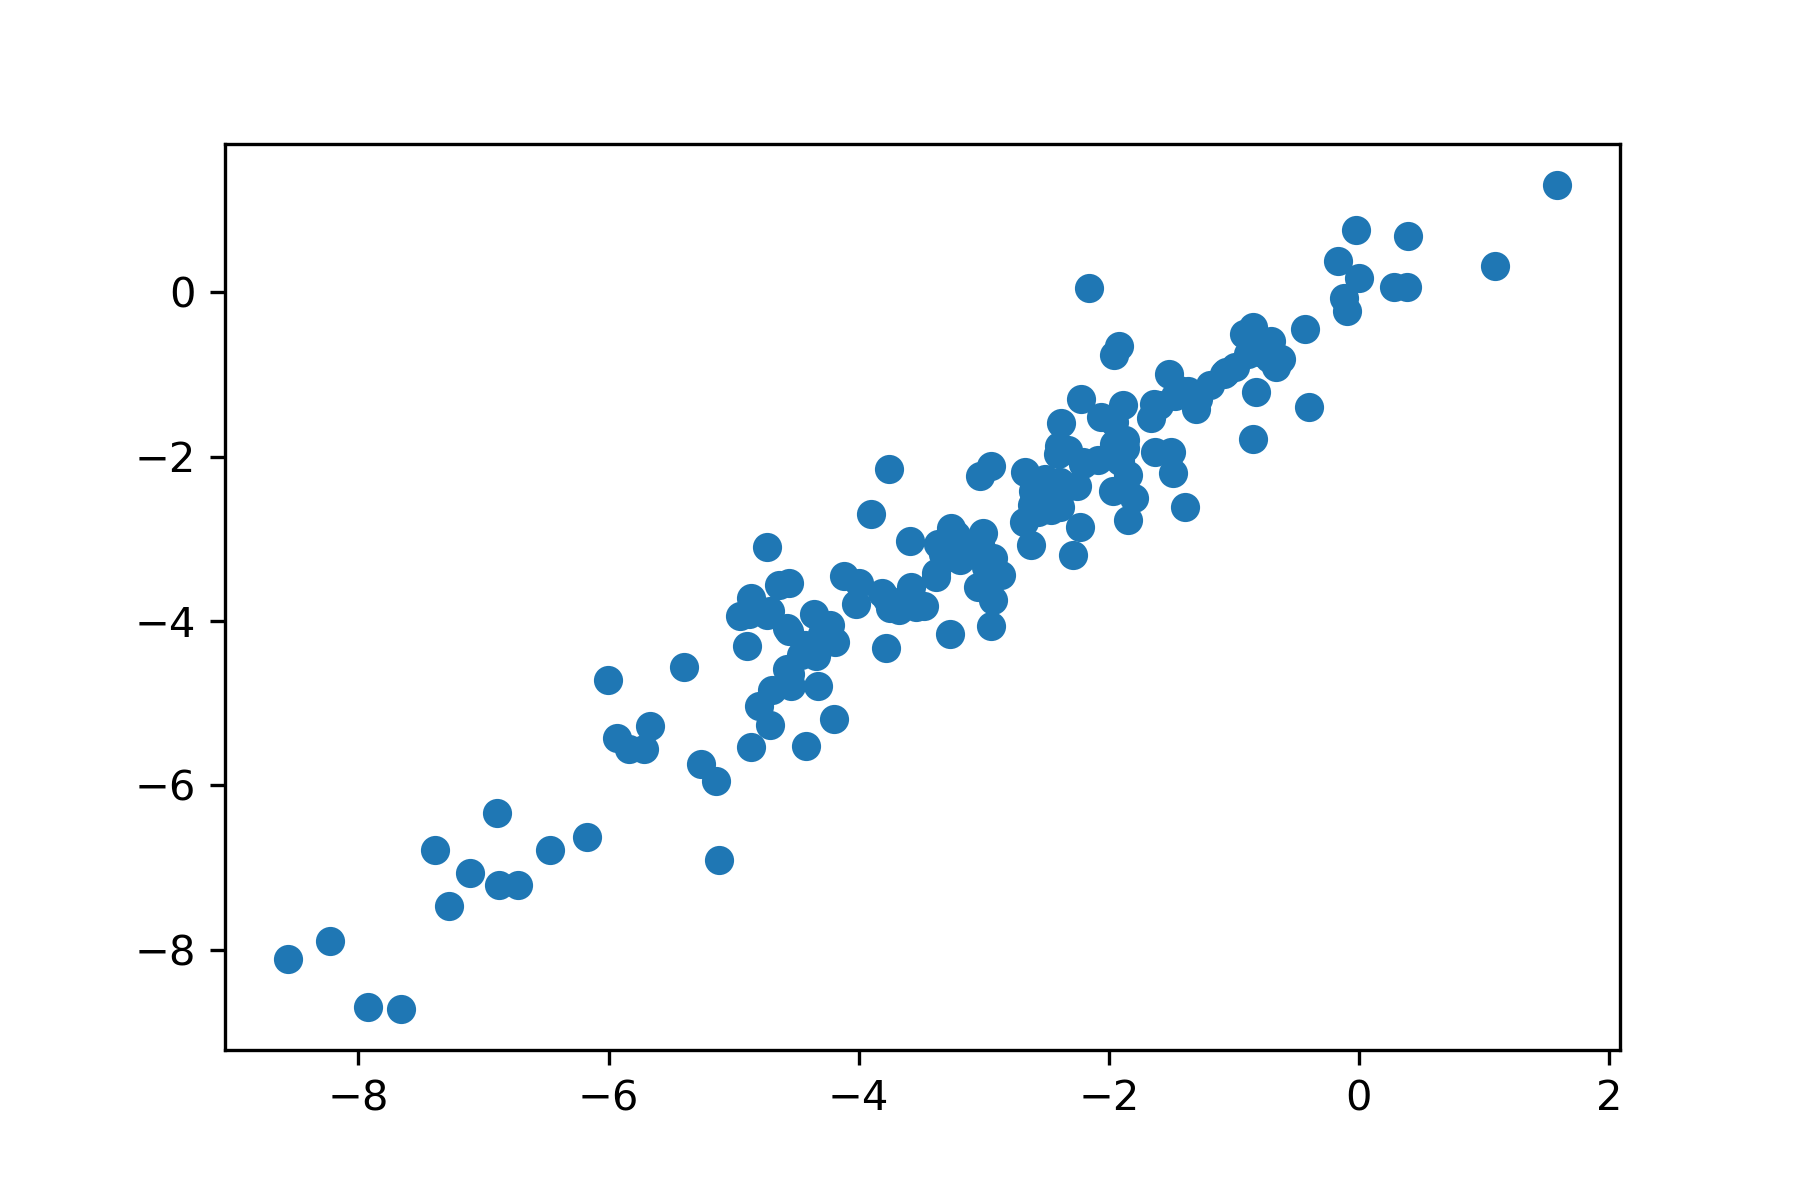

In [19]:
model_ESOLModel1,data_ESOLModel1 = bg.default_model_run(
        "ESOLModel1",
        model_ESOLModel1,
        loader_ESOLModel1,
                      force_run=False,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=1000,
                    early_stopping_delta=0.0,
                   detect_lr=False,
                    early_stop_patience=100,
    )

In [20]:
import numpy as np
#list(model_FGModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_ESOLModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

440407

In [21]:
true=[]
pred=[]
try:
    loader_ESOLModel1.train_dataloader()
except:
    loader_ESOLModel1.setup()
    
for l in [
        #loader_ESOLModel1.train_dataloader(),
          #loader_ESOLModel1.val_dataloader(),
          loader_ESOLModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_ESOLModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y_graph_features.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)


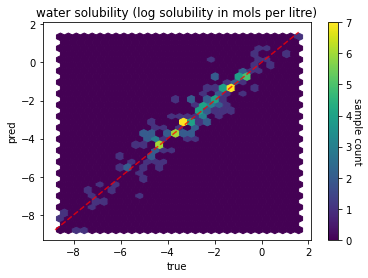

In [25]:
import matplotlib.pyplot as plt

dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

plt.hexbin(true,pred,gridsize=30,)
#plt.plot(true,pred,"o",)
plt.plot([dmin,dmax],[dmin,dmax],"--r",alpha=0.75)
plt.xlabel("true")
plt.ylabel("pred")
plt.title("water solubility (log solubility in mols per litre)")
clb = plt.colorbar() 
clb.set_label('sample count', rotation=270,labelpad=10)
plt.show()
plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [ ]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
np.sqrt((np.abs(pred-true)**2).mean()),np.abs(pred-true).mean()

In [ ]:

                           )
